<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Bivariate-Exploration" data-toc-modified-id="Bivariate-Exploration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Bivariate Exploration</a></span></li></ul></div>

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [3]:
# load in the dataset into a pandas dataframe
diamonds = pd.read_csv('diamonds.csv')

In [4]:
# convert cut, color, and clarity into ordered categorical types
ordinal_var_dict = {'cut': ['Fair','Good','Very Good','Premium','Ideal'],
                    'color': ['J', 'I', 'H', 'G', 'F', 'E', 'D'],
                    'clarity': ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']}

for var in ordinal_var_dict:
    pd_ver = pd.__version__.split(".")
    if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
        ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                    categories = ordinal_var_dict[var])
        diamonds[var] = diamonds[var].astype(ordered_var)
    else: # pre-v0.21
        diamonds[var] = diamonds[var].astype('category', ordered = True,
                                             categories = ordinal_var_dict[var])

## Bivariate Exploration

In the previous notebook, you looked at the univariate distribution of five features in the diamonds dataset: price, carat, cut, color, and clarity. Now, we'll investigate relationships between pairs of these variables, particularly how each of them relate to diamond price.

To start, construct a plot of the price against carat weight. What kind of shape does the relationship between these variables take?

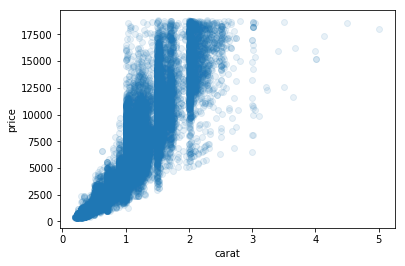

In [5]:
# bivariate plot of price vs. carat
sb.regplot(data=diamonds, y='price', x='carat', fit_reg=False, scatter_kws = {'alpha' : 1/10});

Price vs. Carat comment 1: <span style="color:white">Since these are both numeric variables, a scatterplot is a natural choice. You might also consider a heat map for this task. In either case, you should recall that the price distribution suggests a logarithmic transformation due to its very long tail. If you haven't tried it yet, add a transformation to the price axis.</span>

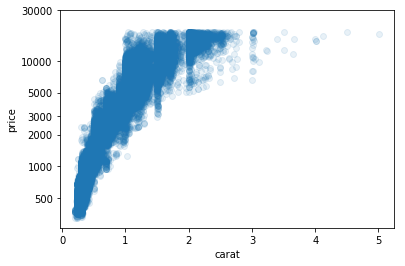

In [6]:
def log_trans(x, inverse = False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)

sb.regplot(y= diamonds['price'].apply(log_trans), x=diamonds['carat'], 
           fit_reg=False, scatter_kws = {'alpha' : 1/10})
ytick_locs = [500, 1000, 2000, 3000, 5000, 10000, 30000]
plt.yticks(log_trans(ytick_locs), ytick_locs);

Price vs. Carat comment 2: <span style="color:white">Assuming that you put price on the y-axis and carat on the x-axis, the transformation should have changed the scatterplot from looking concave upwards (like an upwards-pointing bowl) to concave downards (like a downwards-pointing bowl). It would be nice to have a linear trend, wouldn't it? It turns out that the x, y, and z dimensions track a much more linear trend against price than carat does. Since carat is more recognizable a feature value, let's add a transformation to the x-axis to see the approximately linear trend. Since weight is proportional to volume, and since all the diamonds are cut in approximately the same way (round-cut), a cube-root transformation of carat should allow us to see an approximately linear trend.</span>

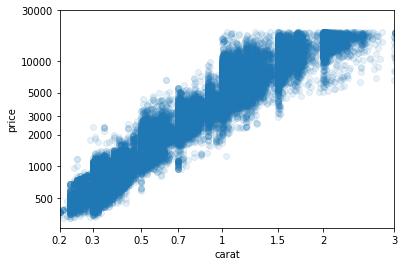

In [7]:
def log_trans(x, inverse = False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)
    
def cuberoot_trans(x, inverse=False):
    if not inverse:
        return np.power(x, 1/3)
    else:
        return np.power(x, 3)
    
sb.regplot(y= diamonds['price'].apply(log_trans), x=diamonds['carat'].apply(cuberoot_trans), 
           fit_reg=False, scatter_kws = {'alpha' : 1/10})
ytick_locs = [500, 1000, 2000, 3000, 5000, 10000, 30000]
xtick_locs = [0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3]
plt.xticks(cuberoot_trans(xtick_locs), xtick_locs)
plt.yticks(log_trans(ytick_locs), ytick_locs)
plt.xlim(cuberoot_trans(0.2),cuberoot_trans(3));

Price vs. Carat comment 3: <span style="color:white">One thing that you might notice in the visualization after transformation is that the trend between price and carat weight is 'cut off' by the maximum price limit of diamonds available in the dataset. For diamonds above about 1.5 carats, we'd probably expect some diamonds about $20,000 in price, given the trend below 1.5 carats. This would be a point to potentially pay attention to later on with interaction effects between other factors, and when building a model of diamond prices.</span>

Now let's take a look at the relationship between price and the three categorical quality features, cut, color, and clarity. Are there any surprising trends to be seen here?

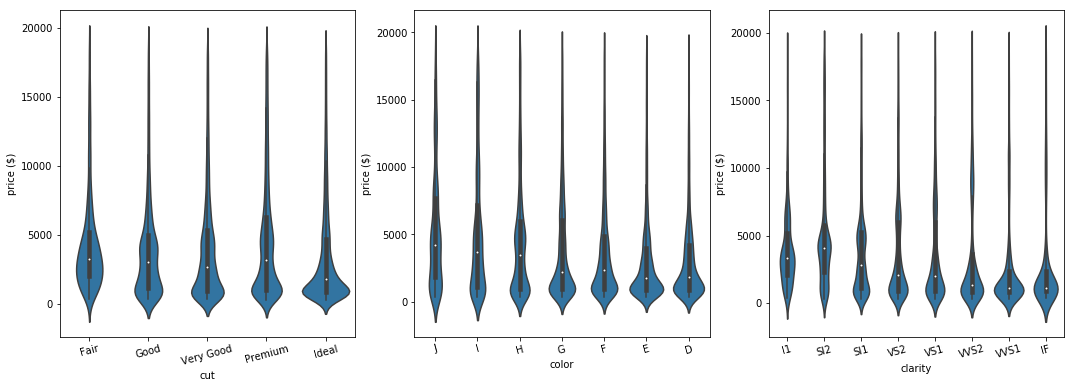

In [17]:
# bivariate plots of price vs. cut, color, clarity
plt.figure(figsize = [18, 6])
base_color = sb.color_palette()[0]

plt.subplot(1, 3, 1)
ax1 = sb.violinplot(data=diamonds, x='cut', y='price', color=base_color, inner='box')
plt.xticks(rotation=15)
plt.ylabel('price ($)')

plt.subplot(1, 3, 2)
ax1 = sb.violinplot(data=diamonds, x='color', y='price', color=base_color, inner='box')
plt.xticks(rotation=15)
plt.ylabel('price ($)')

plt.subplot(1, 3, 3)
ax1 = sb.violinplot(data=diamonds, x='clarity', y='price', color=base_color, inner='box')
plt.xticks(rotation=15)
plt.ylabel('price ($)');

Price vs. Categorical comment 1: <span style="color:white">There's a lot of different approaches you could have taken here. If you created a box plot, then you probably noticed something interesting and unintuitive: the median price of diamonds should tend to look like it _decrease_ with _increasing_ gem quality. Shouldn't we expect this to be the other way around? This deserves a deeper look. Is there a different plot type to choose that shows more details in the data?</span>

Price vs. Categorical comment 2: <span style="color:white">With a violin plot, you can get more insight into what causes the trend in median prices to appear as it does. Faceted histograms will also produce a similar result, though unless the faceting keeps the price axis common across facets, the trend will be harder to see. For each ordinal variable, there are multiple modes into which prices appear to fall. Going across increasing quality levels, you should see that the modes rise in price - this should be the expected effect of quality. However, you should also see that more of the data will be located in the lower-priced modes - this explains the unintuitive result noted in the previous comment. This is clearest in the clarity variable. Let's keep searching the data to see if there's more we can say about this pattern.</span>

Before we complete the bivariate exploration, we should take a look at some of the relationships between the independent variables. Namely, how does carat weight change across the other three 'C' quality measures? You can take the same approach as the above investigation of price against the three categorical quality measures. What can you see in these plots, and how does this relate to your earlier investigations?

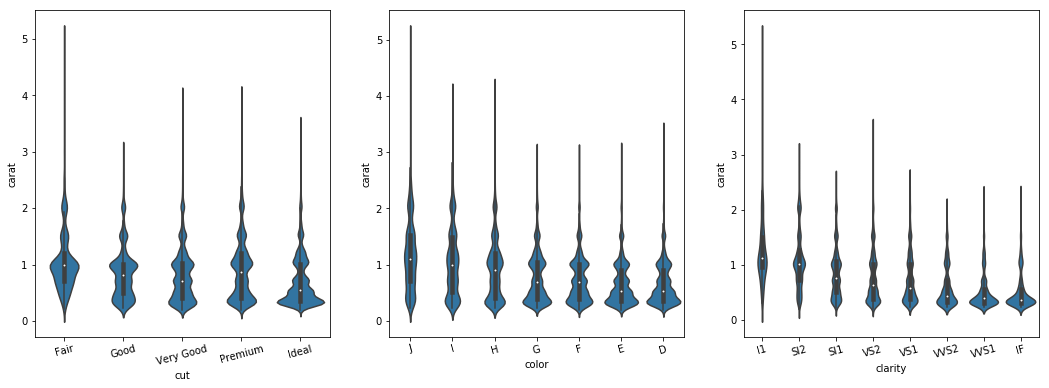

In [20]:
# bivariate plots of carat vs. cut, color, clarity
ax1 = plt.figure(figsize = [18, 6])
base_color = sb.color_palette()[0]

plt.subplot(1, 3, 1)
ax1 = sb.violinplot(data=diamonds, x='cut', y='carat', color=base_color, inner='box')
plt.xticks(rotation=15)
plt.ylabel('carat')

plt.subplot(1, 3, 2)
ax1 = sb.violinplot(data=diamonds, x='color', y='carat', color=base_color, inner='box')
plt.xticks(rotation=15)
plt.ylabel('carat')

plt.subplot(1, 3, 3)
ax1 = sb.violinplot(data=diamonds, x='clarity', y='carat', color=base_color, inner='box')
plt.xticks(rotation=15)
plt.ylabel('carat');

Carat vs. Categorical comment: <span style="color:white">These plots should shed a lot more light into the patterns already seen. Larger diamonds are more likely to receive lower categorical quality grades, while high quality grades are more likely to have their numbers made up of smaller diamonds. Since carat weight appears to be a major driver of price, this helps to explain the surprising marginal effect of diamond quality against price. The challenge next will be on how to depict this in a multivariate plot.</span>